#Install Dependencies

In [1]:
!pip install pandas scikit-learn

#Upload the JSON File

In [2]:
!gdown --id 1ISFbAXxadMrt7Zl96rmzzZmEKZnyW7FS -O user_transactions.json

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ISFbAXxadMrt7Zl96rmzzZmEKZnyW7FS
To: /content/user_transactions.json
100% 91.2M/91.2M [00:00<00:00, 95.0MB/s]


##code

In [3]:
import json
from collections import defaultdict

# Load JSON flat list of txs
with open('user_transactions.json') as f:
    flat_data = json.load(f)

# Group transactions by wallet
wallet_dict = defaultdict(list)
for tx in flat_data:
    wallet = tx.get('wallet')  # or 'user' or 'walletAddress' if named differently
    if wallet:
        wallet_dict[wallet].append(tx)

# Convert to list of {"wallet": ..., "transactions": [...]}
grouped_data = [{"wallet": w, "transactions": txs} for w, txs in wallet_dict.items()]

In [4]:
import json
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict

# Step 1: Load JSON
with open('user_transactions.json') as f:
    flat_data = json.load(f)

# Step 2: Group by userWallet
wallet_dict = defaultdict(list)
for tx in flat_data:
    wallet = tx.get('userWallet')
    if not wallet:
        continue
    action = tx.get('action', '').lower()
    timestamp = int(tx.get('timestamp', 0))

    # Some records may not have actionData or amount
    amount = 0
    if tx.get('actionData') and tx['actionData'].get('amount'):
        try:
            amount = float(tx['actionData']['amount'])
        except:
            amount = 0

    wallet_dict[wallet].append({
        'type': action,
        'timestamp': timestamp,
        'amount': amount
    })

# Step 3: Extract features
def convert_timestamp(ts):
    return datetime.fromtimestamp(int(ts))

def extract_features(wallet_txs):
    types = ['deposit', 'borrow', 'repay', 'redeemunderlying', 'liquidationcall']
    features = {f'count_{t}': 0 for t in types}
    total_value = {t: 0 for t in types}
    timestamps = []

    for tx in wallet_txs:
        t_type = tx['type']
        if t_type in types:
            features[f'count_{t_type}'] += 1
            total_value[t_type] += tx['amount']
            timestamps.append(convert_timestamp(tx['timestamp']))

    features.update({f'total_{k}': v for k, v in total_value.items()})

    # Time-based features
    timestamps.sort()
    if len(timestamps) > 1:
        time_diffs = [(timestamps[i+1] - timestamps[i]).total_seconds() for i in range(len(timestamps)-1)]
        avg_gap = sum(time_diffs) / len(time_diffs)
    else:
        avg_gap = 0
    features['avg_time_gap'] = avg_gap
    features['active_days'] = (timestamps[-1] - timestamps[0]).days if timestamps else 0

    # Ratios
    features['repay_borrow_ratio'] = total_value['repay'] / total_value['borrow'] if total_value['borrow'] else 0
    features['redeem_deposit_ratio'] = total_value['redeemunderlying'] / total_value['deposit'] if total_value['deposit'] else 0

    return features

# Step 4: Score wallets
def score_wallets(df):
    scaler = MinMaxScaler()
    normalized = scaler.fit_transform(df)
    scores = (normalized.mean(axis=1) * 1000).astype(int)
    return scores

# Step 5: Apply
wallet_scores = []
for wallet, txs in wallet_dict.items():
    features = extract_features(txs)
    features['wallet_address'] = wallet
    wallet_scores.append(features)

df = pd.DataFrame(wallet_scores)
feature_cols = [col for col in df.columns if col != 'wallet_address']
df['credit_score'] = score_wallets(df[feature_cols])

# Save & display
df[['wallet_address', 'credit_score']].to_csv('wallet_scores.csv', index=False)
df[['wallet_address', 'credit_score']].head()


,wallet_address,credit_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,0
1,0x000000000051d07a4fb3bd10121a343d85818da6,0
2,0x000000000096026fb41fc39f9875d164bd82e2dc,9
3,0x0000000000e189dd664b9ab08a33c4839953852c,66
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,104


#Visualize Score Distribution

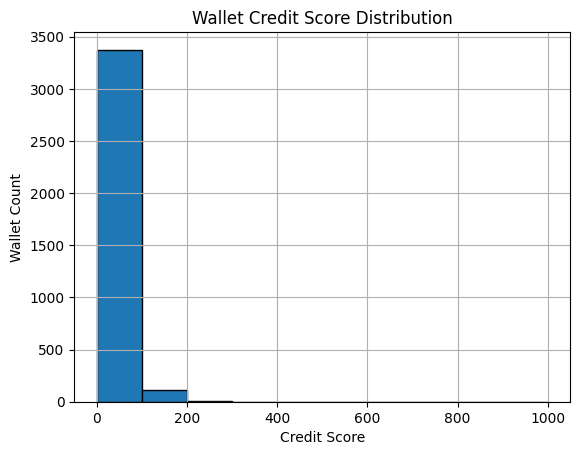

In [5]:
import matplotlib.pyplot as plt

plt.hist(df['credit_score'], bins=10, range=(0,1000), edgecolor='black')
plt.title('Wallet Credit Score Distribution')
plt.xlabel('Credit Score')
plt.ylabel('Wallet Count')
plt.grid(True)
plt.show()
